# Reflectance of a Waveguide Taper

This example involves computing the reflectance of the fundamental mode of a linear waveguide taper. We will verify that computing the reflectance, the fraction of the incident power which is reflected, using two different methods produces nearly identical results: (1) mode decomposition and (2) [Poynting flux](../Introduction.md#transmittancereflectance-spectra). Also, we will demonstrate that the scaling of the reflectance with the taper length is quadratic, consistent with analytical results from [Optics Express, Vol. 16, pp. 11376-92, 2008](http://www.opticsinfobase.org/abstract.cfm?URI=oe-16-15-11376).

The structure, which can be viewed as a [two-port network](https://en.wikipedia.org/wiki/Two-port_network), consists of a single-mode waveguide of width 1 μm (`w1`) at a wavelength of 6.67 μm and coupled to a second waveguide of width 2 μm (`w2`) via a linearly-sloped taper of variable length `Lt`. 

The core material is dispersive silicon and the cladding is dispersive silicon dioxide (imported from the materials library). The taper geometry is defined using a single [`Prism`](../Python_User_Interface.md#prism) object with eight vertices. PML absorbing boundaries surround the entire cell. 

An eigenmode current source with E<sub>z</sub> polarization is used to launch the fundamental mode. The dispersion relation (or "band diagram") of the single-mode waveguide is shown in [Tutorial/Eigenmode Source](Eigenmode_Source.md). 

There is an eigenmode-expansion monitor placed at the midpoint of the first waveguide. This is a line monitor which extends beyond the waveguide in order to span the entire mode profile including its evanescent tails. The Fourier-transformed fields along this line monitor are used to compute the basis coefficients of the harmonic modes. These are computed separately via the eigenmode solver [MPB](https://mpb.readthedocs.io/en/latest/). This is described in [Mode Decomposition](../Mode_Decomposition.md) where it is also shown that the squared magnitude of the mode coefficient is equivalent to the power (Poynting flux) in the given eigenmode. The ratio of the complex mode coefficients can be used to compute the [S parameters](https://en.wikipedia.org/wiki/Scattering_parameters). 

In this example, we are computing |S<sub>11</sub>|<sup>2</sup> which is the reflectance (shown in the line prefixed by "refl:,"). Another line monitor could have been placed in the second waveguide to compute the transmittance or |S<sub>21</sub>|<sup>2</sup> into the various guided modes (since the second waveguide is multi mode). The scattered power into the radiative modes can then be computed as 1-|S<sub>11</sub>|<sup>2</sup>-|S<sub>21</sub>|<sup>2</sup>. As usual, a normalization run is required involving a straight waveguide to compute the power in the source.

The structure has mirror symmetry in the $y$ direction which can be exploited to reduce the computation size by a factor of two. This requires that we use `add_flux` rather than `add_mode_monitor` (which is not optimized for symmetry) and specify `eig_parity=mp.ODD_Z+mp.EVEN_Y` in the call to `get_eigenmode_coefficients`.

First we'll begin by loading our modules and materials from Meep's material library:

In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from meep.materials import Si, SiO2

Using MPI version 3.1, 1 processes


Now we can define our waveguide taper geometric parameters:

In [2]:
w1 = 1.0          # width of waveguide 1
w2 = 2.0          # width of waveguide 2
Lw = 10.0         # length of waveguides 1 and 2
Lt = 2            # length of waveguide taper

We'll specify the simulation domain parameters, such as the simulation resolution, boundary layers, simulation cell size, and we'll also leverage a symmetry across the `X` axis.

In [3]:
resolution = 10   # pixels/μm

dpml_x = 6.0      # length of PML in x direction
dpml_y = 2.0      # length of PML in y direction

boundary_layers = [mp.PML(dpml_x,direction=mp.X),
                   mp.PML(dpml_y,direction=mp.Y)]

sy = dpml_y+dair+w2+dair+dpml_y
sx = dpml_x+Lw+Lt+Lw+dpml_x
cell_size = mp.Vector3(sx,sy,0)

symmetries = [mp.Mirror(mp.Y)]

Next we'll define a straight waveguide structure.

In [5]:
vertices = [mp.Vector3(-0.5*sx-1,0.5*w1),
                mp.Vector3(0.5*sx+1,0.5*w1),
                mp.Vector3(0.5*sx+1,-0.5*w1),
                mp.Vector3(-0.5*sx-1,-0.5*w1)]
geometry=[mp.Prism(vertices,height=mp.inf,material=Si)]

We'll add a broadband Gaussian pulse source.

In [6]:
lcen = 6.67       # mode wavelength
fcen = 1/lcen     # mode frequency
df = 0.2*fcen

src_pt = mp.Vector3(-0.5*sx+dpml_x+0.2*Lw)
sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              center=src_pt,
                              size=mp.Vector3(y=sy-2*dpml_y),
                              eig_match_freq=True,
                              eig_parity=mp.ODD_Z+mp.EVEN_Y)]

We can now formulate our simulation object and add a flux monitor to the simulation. We can use this flux monitor for both the flux calculations and the mode expansion calculations, we just need to be wary of the symmetries. As explained in the documentation, using a flux monitor for mode decomposition calculations does not check for modes that don't follow the specified symmetry. Luckily, we are only solving for the fundamental mode that _does_ obey this symmetry.

In [7]:
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    default_material=SiO2,
                    Courant=0.2,
                    symmetries=symmetries)

mon_pt = mp.Vector3(-0.5*sx+dpml_x+0.7*Lw)
flux = sim.add_flux(fcen,0,1,mp.FluxRegion(center=mon_pt,size=mp.Vector3(y=sy-2*dpml_y)))

We'll visualize the waveguide structure:

-----------
Initializing structure...
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 4 vertices:
          (-18,0.5,0)
          (18,0.5,0)
          (18,-0.5,0)
          (-18,-0.5,0)


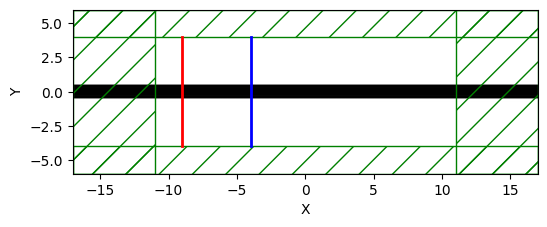

In [8]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

and run the simulation until the fields sufficiently decay.

In [9]:
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,mon_pt,1e-9))

field decay(t = 50.02): 7.671724712517377e-08 / 7.671724712517377e-08 = 1.0
field decay(t = 100.04): 0.001711109540234957 / 0.001711109540234957 = 1.0
field decay(t = 150.06): 0.43146961653905963 / 0.43146961653905963 = 1.0
field decay(t = 200.08): 1.4444436725338514 / 1.4444436725338514 = 1.0
field decay(t = 250.1): 1.1283686988977457 / 1.4444436725338514 = 0.7811787474677742
field decay(t = 300.12): 0.027187427164650984 / 1.4444436725338514 = 0.018822075018653128
field decay(t = 350.14): 7.459562738029179e-06 / 1.4444436725338514 = 5.1643154245977426e-06
field decay(t = 400.16): 2.327626587488428e-11 / 1.4444436725338514 = 1.6114346524882428e-11
run 0 finished at t = 400.16 (20008 timesteps)


We now need to record the fluxes at the monitor so we can use them to normalize the taper responses later.

In [10]:
incident_flux = mp.get_fluxes(flux)

With a "calibration" run stored, we can proceed to the actual taper structure. We'll build our geometry:

In [11]:
vertices = [mp.Vector3(-0.5*sx-1,0.5*w1),
                mp.Vector3(-0.5*Lt,0.5*w1),
                mp.Vector3(0.5*Lt,0.5*w2),
                mp.Vector3(0.5*sx+1,0.5*w2),
                mp.Vector3(0.5*sx+1,-0.5*w2),
                mp.Vector3(0.5*Lt,-0.5*w2),
                mp.Vector3(-0.5*Lt,-0.5*w1),
                mp.Vector3(-0.5*sx-1,-0.5*w1)]
    
geometry=[mp.Prism(vertices,height=mp.inf,material=Si)]

and reformulate our simulation object:

In [12]:
sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    default_material=SiO2,
                    Courant=0.2,
                    symmetries=symmetries)

mon_pt = mp.Vector3(-0.5*sx+dpml_x+0.7*Lw)
flux = sim.add_flux(fcen,0,1,mp.FluxRegion(center=mon_pt,size=mp.Vector3(y=sy-2*dpml_y)))

As usual, we'll visualize the structure:

-----------
Initializing structure...
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 8 vertices:
          (-18,0.5,0)
          (-1,0.5,0)
          (1,1,0)
          (18,1,0)
          (18,-1,0)
          (1,-1,0)
          (-1,-0.5,0)
          (-18,-0.5,0)


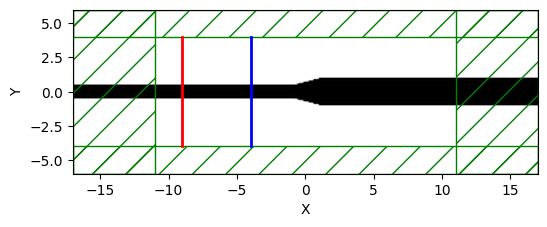

In [13]:
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

As we run this simulation, we'll record the fields so that we can animate the results.

In [14]:
f = plt.figure(dpi=150)
Animate = mp.Animate2D(sim,fields=mp.Ez,f=f,normalize=True)
sim.run(mp.at_every(1,Animate),until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,mon_pt,1e-9))
plt.close()

field decay(t = 50.02): 7.665044540747097e-08 / 7.665044540747097e-08 = 1.0
field decay(t = 100.04): 0.0017067735280092307 / 0.0017067735280092307 = 1.0
field decay(t = 150.06): 0.4284558249322167 / 0.4284558249322167 = 1.0
field decay(t = 200.08): 1.42423139021259 / 1.42423139021259 = 1.0
field decay(t = 250.1): 1.1071170189122674 / 1.42423139021259 = 0.7773435036753487
field decay(t = 300.12): 0.026134485762401943 / 1.42423139021259 = 0.01834988748457576
field decay(t = 350.14): 7.258239687371188e-06 / 1.42423139021259 = 5.096250326492085e-06
field decay(t = 400.16): 3.3493853416812485e-11 / 1.42423139021259 = 2.3517143103981843e-11
Normalizing field data...
run 0 finished at t = 400.16 (20008 timesteps)


We'll export an mp4 video and visualize the results:

In [15]:
filename = "media/taper.mp4"
Animate.to_mp4(10,filename)
Video(filename)

Generating MP4...


As before, we want to record the fluxes.

In [16]:
taper_flux = mp.get_fluxes(flux)
norm_flux = -(taper_flux[0] - incident_flux[0]) /incident_flux[0]

In [17]:
res = sim.get_eigenmode_coefficients(flux,[1],eig_parity=mp.ODD_Z+mp.EVEN_Y)
a = res.alpha[0,0,0]
b = res.alpha[0,0,1]
S11 = b/a

In [18]:
print("Reflected Power calculated by Flux Monitors: {:.2f} dB".format(10*np.log10(norm_flux)))
print("Reflected Power calculated by Mode Expansion Monitors: {:.2f} dB".format(10*np.log10(abs(S11)**2)))

Reflected Power calculated by Flux Monitors: -39.61 dB
Reflected Power calculated by Mode Expansion Monitors: -34.91 dB


In [19]:
def run_sim(Lt):
    sy = dpml_y+dair+w2+dair+dpml_y
    sx = dpml_x+Lw+Lt+Lw+dpml_x
    cell_size = mp.Vector3(sx,sy,0)

    vertices = [mp.Vector3(-0.5*sx-1,0.5*w1),
                mp.Vector3(-0.5*Lt,0.5*w1),
                mp.Vector3(0.5*Lt,0.5*w2),
                mp.Vector3(0.5*sx+1,0.5*w2),
                mp.Vector3(0.5*sx+1,-0.5*w2),
                mp.Vector3(0.5*Lt,-0.5*w2),
                mp.Vector3(-0.5*Lt,-0.5*w1),
                mp.Vector3(-0.5*sx-1,-0.5*w1)]
    
    geometry=[mp.Prism(vertices,height=mp.inf,material=Si)]
    
    src_pt = mp.Vector3(-0.5*sx+dpml_x+0.2*Lw,0,0)
    sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              center=src_pt,
                              size=mp.Vector3(y=sy-2*dpml_y),
                              eig_match_freq=True,
                              eig_parity=mp.ODD_Z+mp.EVEN_Y)]
    
    sim = mp.Simulation(resolution=resolution,
                    cell_size=cell_size,
                    boundary_layers=boundary_layers,
                    geometry=geometry,
                    sources=sources,
                    Courant=0.2,
                    symmetries=symmetries)

    mon_pt = mp.Vector3(-0.5*sx+dpml_x+0.7*Lw,0,0)
    flux = sim.add_flux(fcen,0,1,mp.FluxRegion(center=mon_pt,size=mp.Vector3(y=sy-2*dpml_y)))
    
    f = plt.figure(dpi=100)
    sim.plot2D(ax=f.gca())
    plt.show()
    
    sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,mon_pt,1e-9))
    
    taper_flux = mp.get_fluxes(flux)
    norm_flux = -(taper_flux[0] - incident_flux[0]) /incident_flux[0]
    
    res = sim.get_eigenmode_coefficients(flux,[1],eig_parity=mp.ODD_Z+mp.EVEN_Y)
    a = res.alpha[0,0,0]
    b = res.alpha[0,0,1]
    S11 = b/a
    
    return S11, norm_flux

-----------
Initializing structure...
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 8 vertices:
          (-17.5,0.5,0)
          (-0.5,0.5,0)
          (0.5,1,0)
          (17.5,1,0)
          (17.5,-1,0)
          (0.5,-1,0)
          (-0.5,-0.5,0)
          (-17.5,-0.5,0)


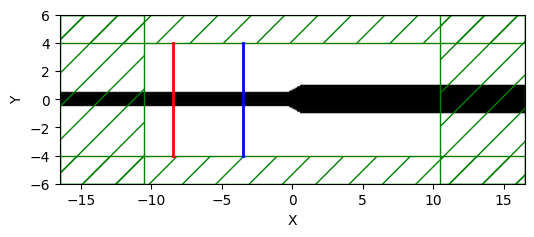

field decay(t = 50.02): 7.532138149008362e-08 / 7.532138149008362e-08 = 1.0
field decay(t = 100.04): 0.0017051550185107221 / 0.0017051550185107221 = 1.0
field decay(t = 150.06): 0.4371997396195332 / 0.4371997396195332 = 1.0
field decay(t = 200.08): 1.4769831857208346 / 1.4769831857208346 = 1.0
field decay(t = 250.1): 1.1563514776633275 / 1.4769831857208346 = 0.7829144494281941
field decay(t = 300.12): 0.02773474018159078 / 1.4769831857208346 = 0.018777966093131232
field decay(t = 350.14): 7.4174871213078184e-06 / 1.4769831857208346 = 5.0220525142185346e-06
field decay(t = 400.16): 1.497827335557877e-11 / 1.4769831857208346 = 1.0141126520860625e-11
run 0 finished at t = 400.16 (20008 timesteps)
-----------
Initializing structure...
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 8 vertices:
          (-18,0.5,0)
          (-1,0.5,0)
          (1,1,0)
          (18,1,0)
          (18,-1,0)
          (1,-1,0)
          (-1,-0.5,0)
          (-18,-0.5,0)


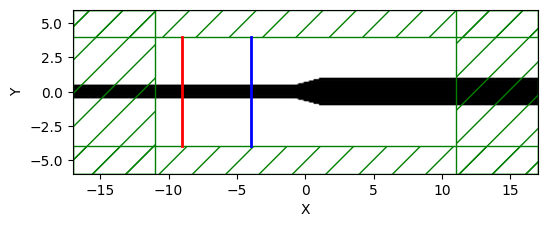

field decay(t = 50.02): 7.532106140043022e-08 / 7.532106140043022e-08 = 1.0
field decay(t = 100.04): 0.001704705712458036 / 0.001704705712458036 = 1.0
field decay(t = 150.06): 0.43698277965249527 / 0.43698277965249527 = 1.0
field decay(t = 200.08): 1.4756968304289273 / 1.4756968304289273 = 1.0
field decay(t = 250.1): 1.154942829505321 / 1.4756968304289273 = 0.7826423461041279
field decay(t = 300.12): 0.02771963217854962 / 1.4756968304289273 = 0.018784096846296408
field decay(t = 350.14): 7.844222081656643e-06 / 1.4756968304289273 = 5.3156054278280415e-06
field decay(t = 400.16): 3.607541510177056e-11 / 1.4756968304289273 = 2.444635941332533e-11
run 0 finished at t = 400.16 (20008 timesteps)
-----------
Initializing structure...
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 8 vertices:
          (-19,0.5,0)
          (-2,0.5,0)
          (2,1,0)
          (19,1,0)
          (19,-1,0)
          (2,-1,0)
          (-2,-0.5,0)
          (-19,-0.5,0)


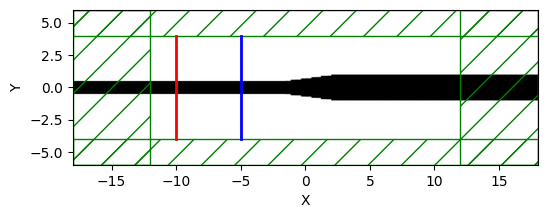

field decay(t = 50.02): 7.540970309882117e-08 / 7.540970309882117e-08 = 1.0
field decay(t = 100.04): 0.0017096426522496403 / 0.0017096426522496403 = 1.0
field decay(t = 150.06): 0.4407822782593014 / 0.4407822782593014 = 1.0
field decay(t = 200.08): 1.504113815445071 / 1.504113815445071 = 1.0
field decay(t = 250.1): 1.1871615355078764 / 1.504113815445071 = 0.7892763987122825
field decay(t = 300.12): 0.030444540384104865 / 1.504113815445071 = 0.020240848845003295
field decay(t = 350.14): 1.343394203571941e-05 / 1.504113815445071 = 8.931466420806908e-06
field decay(t = 400.16): 5.271393154792646e-10 / 1.504113815445071 = 3.5046504464376767e-10
run 0 finished at t = 400.16 (20008 timesteps)
-----------
Initializing structure...
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 8 vertices:
          (-21,0.5,0)
          (-4,0.5,0)
          (4,1,0)
          (21,1,0)
          (21,-1,0)
          (4,-1,0)
          (-4,-0.5,0)
          (-21,-0.5,0)


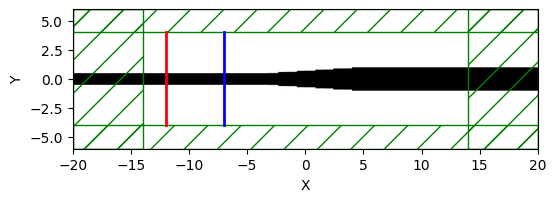

field decay(t = 50.02): 7.539458435567761e-08 / 7.539458435567761e-08 = 1.0
field decay(t = 100.04): 0.0017071022210222542 / 0.0017071022210222542 = 1.0
field decay(t = 150.06): 0.43806151519633907 / 0.43806151519633907 = 1.0
field decay(t = 200.08): 1.477976660786621 / 1.477976660786621 = 1.0
field decay(t = 250.1): 1.1536664677202135 / 1.477976660786621 = 0.7805715058492193
field decay(t = 300.12): 0.026039473422046544 / 1.477976660786621 = 0.01761832518260985
field decay(t = 350.14): 1.545260578908996e-06 / 1.477976660786621 = 1.0455243441304172e-06
field decay(t = 400.16): 2.46219320531304e-09 / 1.477976660786621 = 1.6659215741624712e-09
field decay(t = 450.18): 2.680311359908484e-13 / 1.477976660786621 = 1.8135004638584392e-13
run 0 finished at t = 450.18 (22509 timesteps)
-----------
Initializing structure...
     prism, center = (0,0,5e+19)
          height 1e+20, axis (0,0,1), 8 vertices:
          (-25,0.5,0)
          (-8,0.5,0)
          (8,1,0)
          (25,1,0)
          

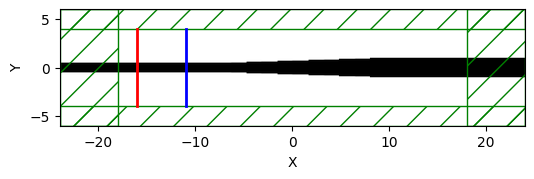

field decay(t = 50.02): 7.539224154876858e-08 / 7.539224154876858e-08 = 1.0
field decay(t = 100.04): 0.00171002598314734 / 0.00171002598314734 = 1.0
field decay(t = 150.06): 0.44173623804545514 / 0.44173623804545514 = 1.0
field decay(t = 200.08): 1.5208474532993095 / 1.5208474532993095 = 1.0
field decay(t = 250.1): 1.214870499464329 / 1.5208474532993095 = 0.7988115420970081
field decay(t = 300.12): 0.03898351708565264 / 1.5208474532993095 = 0.025632759551973628
field decay(t = 350.14): 0.0007686249211665365 / 1.5208474532993095 = 0.0005053925161916076
field decay(t = 400.16): 5.365869286730016e-05 / 1.5208474532993095 = 3.528210061495227e-05
field decay(t = 450.18): 1.5083849534268432e-07 / 1.5208474532993095 = 9.91805555616094e-08
field decay(t = 500.2): 2.0602770615385525e-12 / 1.5208474532993095 = 1.3546901479625787e-12
run 0 finished at t = 500.2 (25010 timesteps)


In [20]:
S11 = []
norm_flux = []
Lt_range = []
for m in range(5):
    Lt = 2**m
    S11_cur, norm_flux_curr = run_sim(Lt)
    S11.append(S11_cur)
    norm_flux.append(norm_flux_curr)
    Lt_range.append(Lt)

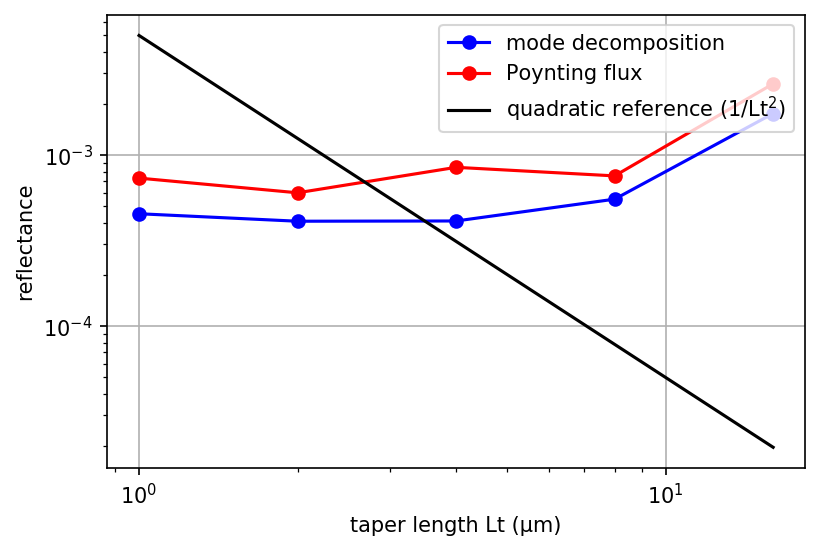

In [21]:
plt.figure(dpi=150)
plt.loglog(Lt_range,abs(np.array(S11))**2,'bo-',label='mode decomposition')
plt.loglog(Lt_range,norm_flux,'ro-',label='Poynting flux')
plt.loglog(Lt_range,[0.005/Lt**2 for Lt in Lt_range],'k-',label=r'quadratic reference (1/Lt$^2$)')
plt.legend(loc='upper right')
plt.xlabel('taper length Lt (μm)')
plt.ylabel('reflectance')
plt.grid(True)
plt.show()